Part 1: Set Up YOLO Model and Video Input

This part will load the YOLOv8 model, open the video file, and set up the output video file along with the logging system.

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import time

model = YOLO('yolov8x.pt')

video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    exit()

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video setup
output_path = 'final_output_video8.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Log file setup
output_txt_path = 'detection_log8.txt'
with open(output_txt_path, 'w', encoding='utf-8') as log_file:
    log_file.write('Báo cáo phát hiện vật nguy hiểm\n')
    log_file.write('----------------------------\n')

# Create background subtractor for novel object detection
backSub = cv2.createBackgroundSubtractorMOG2(history=700, varThreshold=25, detectShadows=False)

Part 2: Lane Detection Function

This section defines the lane detection function, which will be used in the main loop.

In [2]:
def detect_lanes(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Define bounds for road color in HSV
    lower_road_color = np.array([0, 0, 50])
    upper_road_color = np.array([180, 255, 255])
    road_mask = cv2.inRange(hsv, lower_road_color, upper_road_color)
    masked_frame = cv2.bitwise_and(frame, frame, mask=road_mask)

    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    # Define a region of interest (ROI) to focus only on the bottom half of the frame, converging toward the center
    mask = np.zeros_like(edges)
    
    # Create a trapezoid-shaped region focusing on lanes that converge toward the center
    polygon = np.array([[
        (int(width * 0.1), height),  # Bottom-left corner (10% from the left)
        (int(width * 0.9), height),  # Bottom-right corner (90% from the right)
        (int(width * 0.6), int(height * 0.6)),  # Top-right of trapezoid (60% of the width, 60% of the height)
        (int(width * 0.4), int(height * 0.6))   # Top-left of trapezoid (40% of the width, 60% of the height)
    ]], np.int32)
    
    cv2.fillPoly(mask, polygon, 255)

    # Apply the mask to the edges to ignore everything outside the region of interest
    cropped_edges = cv2.bitwise_and(edges, mask)

    # Hough line detection to detect lane lines (adjust minLineLength and maxLineGap for longer, more consistent lanes)
    lines = cv2.HoughLinesP(cropped_edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=50)

    line_image = np.zeros_like(frame)
    lane_polygon = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if x2 - x1 == 0:
                slope = float('inf')
            else:
                slope = (y2 - y1) / (x2 - x1)
            if abs(slope) > 0.5:
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 10)
                lane_polygon.append((x1, y1))
                lane_polygon.append((x2, y2))

    if lane_polygon:
        lane_polygon = np.array([lane_polygon], np.int32)
    else:
        lane_polygon = np.array([[(int(width * 0.1), height), (int(width * 0.9), height), 
                                  (int(width * 0.6), int(height * 0.6)), (int(width * 0.4), int(height * 0.6))]], np.int32)
    lane_detected_frame = cv2.addWeighted(frame, 0.8, line_image, 1, 1)

    return lane_detected_frame, lane_polygon

Part 3: Object Position Calculation and Collision Avoidance

This defines the helper functions for calculating the car's position, relative distance, and the logic for avoiding collisions.

In [3]:
def is_in_lane(contour, lane_polygon):
    x, y, w, h = cv2.boundingRect(contour)
    center_x, center_y = x + w // 2, y + h // 2
    return cv2.pointPolygonTest(lane_polygon, (center_x, center_y), False) >= 0

def calculate_car_position(lane_polygon):
    if len(lane_polygon) > 0:
        lane_center_x = (lane_polygon[0][0][0] + lane_polygon[0][1][0]) // 2
        return lane_center_x
    return None

def calculate_relative_distance(object_width, frame_width):
    relative_distance = frame_width / object_width
    return relative_distance

def can_change_lane(lane_polygon, obj_position, obj_width):
    lane_left = lane_polygon[0][0][0]
    lane_right = lane_polygon[0][1][0]

    if obj_position < lane_left:
        return True
    if obj_position > lane_right:
        return True
    return False

def avoid_collision(car_position, object_position, object_width, lane_polygon, vehicle_speed, object_name, relative_distance, current_frame, fps, is_novel=False):
    global last_detection_frame
    lane_left = lane_polygon[0][0][0]
    lane_right = lane_polygon[0][1][0]

    frames_per_second = fps

    if current_frame - last_detection_frame < frames_per_second:
        return vehicle_speed

    if relative_distance > 5:
        if not is_novel:
            print(f"Đối tượng {object_name} ở quá xa, không cần tránh.")
        return vehicle_speed

    if object_position < car_position:
        if can_change_lane(lane_polygon, object_position, object_width):
            action = "Né tránh vật cản sang phải"
        else:
            action = "Giảm tốc độ"
            vehicle_speed *= 0.5
    elif object_position > car_position:
        if can_change_lane(lane_polygon, object_position, object_width):
            action = "Né tránh vật cản sang trái"
        else:
            action = "Giảm tốc độ"
            vehicle_speed *= 0.5
    else:
        action = "Đối tượng ngay phía trước, giảm tốc"
        vehicle_speed *= 0.3
    detection_time_in_video = current_frame / fps

    with open(output_txt_path, 'a', encoding='utf-8') as log_file:
        log_file.write(f"Thời gian phát hiện trong video: {detection_time_in_video:.2f} giây\n")
        log_file.write(f"Vật nguy hiểm: {'Novel Object' if is_novel else object_name}\n")
        log_file.write(f"Vị trí vật so với xe: {'Trái' if object_position < car_position else 'Phải' if object_position > car_position else 'Phía trước'}\n")
        log_file.write(f"Hành động của xe: {action}\n")
        log_file.write(f"Khoảng cách ước tính: {relative_distance:.2f}\n")
        log_file.write('----------------------------\n')
    last_detection_frame = current_frame
    return vehicle_speed

Part 4: Main Loop to Process Frames

Finally, you can put the main loop for frame processing:

In [4]:
vehicle_speed = 40
frame_count = 0
detect_interval = 5
last_detection_frame = 0
latencies = []
fps_values = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    start_time = time.time()

    # Apply background subtraction for novel object detection
    fg_mask = backSub.apply(frame)
    _, fg_mask = cv2.threshold(fg_mask, 240, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(fg_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Detect lanes
    lane_frame, lane_polygon = detect_lanes(frame)
    annotated_frame = lane_frame.copy()

    # YOLO known object detection every 'detect_interval' frames
    if frame_count % detect_interval == 0:
        results = model(frame)
        annotated_frame = results[0].plot()

    # Calculate car's position in the lane
    car_position = calculate_car_position(lane_polygon)

    # Process YOLO results for collision avoidance
    if frame_count % detect_interval == 0:
        for result in results:
            for obj in result.boxes:
                if obj.cls.numel() == 0 or obj.xywh.numel() == 0:
                    continue
                cls_id = int(obj.cls[0])
                object_name = model.names[cls_id]
                x, y, w, h = obj.xywh[0].cpu().numpy()
                object_position = int(x)
                relative_distance = calculate_relative_distance(w, width)
                vehicle_speed = avoid_collision(car_position, object_position, int(w), lane_polygon, vehicle_speed, object_name, relative_distance, frame_count, fps)               

    # Process novel objects
    for contour in contours:
        if cv2.contourArea(contour) < 3000:
            continue
        if is_in_lane(contour, lane_polygon):
            (x, y, w, h) = cv2.boundingRect(contour)
            cv2.rectangle(annotated_frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(annotated_frame, "Novel Object", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            relative_distance = calculate_relative_distance(w, width)
            vehicle_speed = avoid_collision(car_position, x + w // 2, w, lane_polygon, vehicle_speed, "Novel Object", relative_distance, frame_count, fps, is_novel=True)

    final_frame = cv2.addWeighted(lane_frame, 0.7, annotated_frame, 0.3, 0)

    end_time = time.time()
    latency = end_time - start_time
    fps = 1 / latency if latency > 0 else 0
    latencies.append(latency)
    fps_values.append(fps)
    print(f'Latency per frame: {latency:.4f} seconds')
    print(f'Frames per second (FPS): {fps:.2f}')

    out.write(final_frame)
    cv2.imshow('YOLOv8 + Lane Detection + Novel Object Detection', final_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

Latency per frame: 0.0379 seconds
Frames per second (FPS): 26.39
Latency per frame: 0.0439 seconds
Frames per second (FPS): 22.77
Latency per frame: 0.0449 seconds
Frames per second (FPS): 22.28
Latency per frame: 0.0519 seconds
Frames per second (FPS): 19.28

0: 640x384 (no detections), 168.6ms
Speed: 3.0ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Latency per frame: 5.4366 seconds
Frames per second (FPS): 0.18
Latency per frame: 0.0598 seconds
Frames per second (FPS): 16.71
Latency per frame: 0.0618 seconds
Frames per second (FPS): 16.17
Latency per frame: 0.0588 seconds
Frames per second (FPS): 16.99
Latency per frame: 0.0608 seconds
Frames per second (FPS): 16.44

0: 640x384 (no detections), 201.5ms
Speed: 2.0ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)
Latency per frame: 0.2673 seconds
Frames per second (FPS): 3.74
Latency per frame: 0.0628 seconds
Frames per second (FPS): 15.92
Latency per frame

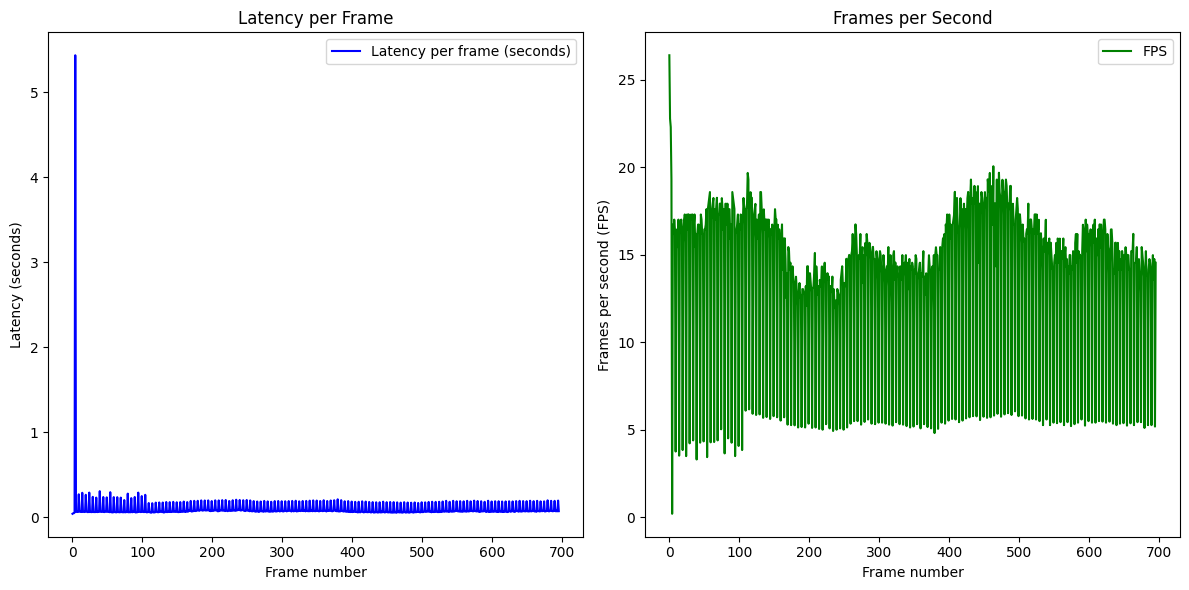

In [5]:
import matplotlib.pyplot as plt

# Plot Latency and FPS using matplotlib
plt.figure(figsize=(12, 6))

# Plot latency per frame
plt.subplot(1, 2, 1)
plt.plot(latencies, label='Latency per frame (seconds)', color='blue')
plt.xlabel('Frame number')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Frame')
plt.legend()

# Plot FPS per frame
plt.subplot(1, 2, 2)
plt.plot(fps_values, label='FPS', color='green')
plt.xlabel('Frame number')
plt.ylabel('Frames per second (FPS)')
plt.title('Frames per Second')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()